In [1]:
import numpy as np
import librosa
from scipy import stats, signal
import pandas as pd
from scipy.fft import fft
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [2]:
def extract_enhanced_mfcc_features(mfcc_matrix):
    """
    Extract enhanced features from MFCC coefficients matrix, specifically designed
    for music and voice classification.
    
    Returns:
    dict: Dictionary containing extracted features
    """
    features = {}
    
    # 1. Basic Statistical Features 
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Calculate first-order deltas (velocity)
        delta = librosa.feature.delta(coeff.reshape(1, -1), width=19)
        
        # Calculate second-order deltas (acceleration)
        delta_delta = librosa.feature.delta(delta, order=2, width=19)
        
        # Basic statistics for original coefficients
        features[f'mfcc{i}_mean'] = np.mean(coeff)
        features[f'mfcc{i}_std'] = np.std(coeff)
        features[f'mfcc{i}_median'] = np.median(coeff)
        
        # Statistics for deltas (velocity features)
        features[f'mfcc{i}_delta_mean'] = np.mean(delta)
        features[f'mfcc{i}_delta_std'] = np.std(delta)
        features[f'mfcc{i}_delta_max'] = np.max(np.abs(delta))
        
        # Statistics for delta-deltas (acceleration features)
        features[f'mfcc{i}_delta2_mean'] = np.mean(delta_delta)
        features[f'mfcc{i}_delta2_std'] = np.std(delta_delta)
        features[f'mfcc{i}_delta2_max'] = np.max(np.abs(delta_delta))
        
        # Temporal variation features
        features[f'mfcc{i}_delta_zero_crossings'] = np.sum(np.diff(np.signbit(delta)))
        features[f'mfcc{i}_delta2_zero_crossings'] = np.sum(np.diff(np.signbit(delta_delta)))
        
        # Energy-related features
        features[f'mfcc{i}_delta_energy'] = np.sum(delta ** 2)
        features[f'mfcc{i}_delta2_energy'] = np.sum(delta_delta ** 2)
        
        # Ratio features
        features[f'mfcc{i}_delta_energy_ratio'] = features[f'mfcc{i}_delta_energy'] / np.sum(coeff ** 2)
        features[f'mfcc{i}_delta2_energy_ratio'] = features[f'mfcc{i}_delta2_energy'] / features[f'mfcc{i}_delta_energy']

    # 2. Rhythm-based Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Detect peaks in the coefficient
        peaks, _ = signal.find_peaks(coeff)
        if len(peaks) > 1:
            # Average distance between peaks (rhythm indicator)
            features[f'mfcc{i}_peak_distance_mean'] = np.mean(np.diff(peaks))
            features[f'mfcc{i}_peak_distance_std'] = np.std(np.diff(peaks))
        else:
            features[f'mfcc{i}_peak_distance_mean'] = 0
            features[f'mfcc{i}_peak_distance_std'] = 0
        
        # Number of peaks normalized by length
        features[f'mfcc{i}_peak_density'] = len(peaks) / len(coeff)
    
    # 3. Spectral Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # FFT for frequency analysis
        fft_vals = np.abs(fft(coeff))
        
        # Spectral centroid (brightness of sound)
        freqs = np.fft.fftfreq(len(coeff))
        features[f'mfcc{i}_spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        
        # Spectral rolloff (shape of spectrum)
        cumsum = np.cumsum(fft_vals)
        rolloff_point = np.where(cumsum >= 0.85 * cumsum[-1])[0][0]
        features[f'mfcc{i}_spectral_rolloff'] = rolloff_point / len(fft_vals)
    
    # 4. Temporal Segmentation Features
    segment_size = mfcc_matrix.shape[1] // 3  # Split into three segments
    
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        features[f'mfcc{i}_begin_mean'] = np.mean(coeff[:segment_size])
        features[f'mfcc{i}_middle_mean'] = np.mean(coeff[segment_size:2*segment_size])
        features[f'mfcc{i}_end_mean'] = np.mean(coeff[2*segment_size:])
    
    # 5. Cross-MFCC Dynamic Features
    # Compute pairwise differences between consecutive frames
    deltas = np.diff(mfcc_matrix, axis=1)
    
    # Overall dynamics
    features['total_dynamics'] = np.mean(np.abs(deltas))
    features['dynamics_std'] = np.std(deltas)
    
    # Compute acceleration (second-order differences)
    accel = np.diff(deltas, axis=1)
    features['total_acceleration'] = np.mean(np.abs(accel))
    features['acceleration_std'] = np.std(accel)
    
    # 6. Structural Features
    # Silence detection (low energy frames)
    energy = np.sum(mfcc_matrix ** 2, axis=0)
    silence_threshold = np.mean(energy) * 0.1
    silence_frames = np.sum(energy < silence_threshold)
    features['silence_ratio'] = silence_frames / len(energy)
    
    # Variation over time windows
    window_size = min(100, mfcc_matrix.shape[1] // 10)
    for i in range(0, 20, 4):  # Take every 4th coefficient to reduce dimensionality
        coeff = mfcc_matrix[i, :]
        windows = np.array_split(coeff, 10)  # Split into 10 windows
        window_means = [np.mean(w) for w in windows]
        features[f'mfcc{i}_temporal_variation'] = np.std(window_means)
    
    return features

def get_feature_importance(X, y, n_estimators=100):
    """
    Train a Random Forest classifier and return feature importance
    """
    from sklearn.ensemble import RandomForestClassifier
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance_dict = dict(zip(X.columns, rf.feature_importances_))
    return dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

def visualize_features(features_df, target_labels=None):
    """
    Create visualizations of the features
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(features_df[numeric_cols].corr(), cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    if target_labels is not None:
        # Box plots for top features by class
        for col in numeric_cols[:5]:  
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_labels, y=features_df[col])
            plt.title(f'{col} Distribution by Class')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [3]:

# Read the files
def natural_sort_key(file_name):
    return [int(num) if num.isdigit() else num for num in re.split(r'(\d+)', file_name)]

file_names = sorted(glob.glob('MFCC-files-v2/*.csv'), key=natural_sort_key)

features_df = pd.DataFrame([extract_enhanced_mfcc_features(pd.read_csv(f, header=None).values) for f in file_names])


In [4]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(features_df)
data_standardized_df = pd.DataFrame(data_standardized, columns=features_df.columns)
# data_standardized_df.to_csv("test_data_features.csv")


In [5]:
def cluster_and_visualize(features_df, file_names, n_clusters=6):
    """
    Perform clustering and create visualizations
    
    Parameters:
    features_df: DataFrame containing only numerical features
    file_names: list of file names corresponding to the features
    n_clusters: number of clusters to create
    """
    # Prepare data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # Perform clustering
    # 1. K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # 2. Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    # Calculate distance matrix
    dist_matrix = euclidean_distances(X_scaled)
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # 1. Distance matrix heatmap
    plt.subplot(131)
    sns.heatmap(dist_matrix, cmap='coolwarm', center=0)
    plt.title('Euclidean Distance Heatmap')
    
    # 2. K-means cluster visualization
    plt.subplot(132)
    cluster_matrix = np.zeros((len(kmeans_labels), len(kmeans_labels)))
    for i in range(len(kmeans_labels)):
        for j in range(len(kmeans_labels)):
            cluster_matrix[i, j] = kmeans_labels[i] == kmeans_labels[j]
    sns.heatmap(cluster_matrix, cmap='coolwarm')
    plt.title('K-means Clusters')
    
    # 3. Hierarchical cluster visualization
    plt.subplot(133)
    cluster_matrix = np.zeros((len(hierarchical_labels), len(hierarchical_labels)))
    for i in range(len(hierarchical_labels)):
        for j in range(len(hierarchical_labels)):
            cluster_matrix[i, j] = hierarchical_labels[i] == hierarchical_labels[j]
    sns.heatmap(cluster_matrix, cmap='coolwarm')
    plt.title('Hierarchical Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'kmeans_labels': kmeans_labels,
        'hierarchical_labels': hierarchical_labels,
        'distance_matrix': dist_matrix
    }

def analyze_clusters(file_names, labels, distance_matrix):
    results = {}
    
    # For each cluster
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        
        cluster_files = [file_names[i] for i in cluster_indices]
        
        # Calculate average distance within cluster
        cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
        avg_distance = np.mean(cluster_distances)
        
        results[f'Cluster_{cluster_id}'] = {
            'size': len(cluster_files),
            'files': cluster_files,
            'avg_distance': avg_distance
        }
    
    return results

def create_detailed_heatmap(distance_matrix, file_names, labels=None):
  
    plt.figure(figsize=(12, 10))
       
    if labels is not None:
        sort_idx = np.argsort(labels)
        distance_matrix = distance_matrix[sort_idx][:, sort_idx]
        file_names = [file_names[i] for i in sort_idx]
    
    # Create heatmap
    sns.heatmap(distance_matrix, 
                xticklabels=[f.split('/')[-1] for f in file_names],  
                yticklabels=[f.split('/')[-1] for f in file_names],
                cmap='coolwarm',
                center=0)
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('Song Similarity Heatmap')
    plt.tight_layout()
    plt.show()

In [6]:
def evaluate_clustering(X, labels, method_name=""):
    
    metrics = {}
    
    # Handle cases where all points might be noise (DBSCAN special case)
    if len(np.unique(labels)) < 2:
        return {
            'silhouette': 0,
            'davies_bouldin': 0,
            'dunn': 0,
            'calinski_harabasz': 0,
            'noise_points': np.sum(labels == -1)
        }
    
    # Calculate metrics
    metrics['silhouette'] = silhouette_score(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics['noise_points'] = np.sum(labels == -1) if -1 in labels else 0
    
    return metrics

def print_clustering_metrics(metrics, method_name=""):
    
    print(f"\n{'-'*20} Clustering Evaluation: {method_name} {'-'*20}")
    print(f"Silhouette Score: {metrics['silhouette']:.3f}")
    print(f"Davies-Bouldin Index: {metrics['davies_bouldin']:.3f}")
    print(f"Calinski-Harabasz Index: {metrics['calinski_harabasz']:.3f}")

# def find_optimal_clusters(X, k_range=range(2, 11)):
    
#     results = {
#         'silhouette': [],
#         'davies_bouldin': [],
#         'calinski_harabasz': []
#     }
    
#     for k in k_range:
#         # k-means clustering
#         kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#         labels = kmeans.fit_predict(X)
        
#         #  metrics
#         metrics = evaluate_clustering(X, labels)
#         for metric_name, value in metrics.items():
#             results[metric_name].append(value)
    
#     # Find optimal k for each metric
#     optimal_k = {
#         'silhouette': k_range[np.argmax(results['silhouette'])],
#         'davies_bouldin': k_range[np.argmin(results['davies_bouldin'])],
#         'dunn': k_range[np.argmax(results['dunn'])],
#         'calinski_harabasz': k_range[np.argmax(results['calinski_harabasz'])]
#     }
    
#     # Visualize results
#     plt.figure(figsize=(15, 10))
    
#     plt.subplot(221)
#     plt.plot(k_range, results['silhouette'])
#     plt.title('Silhouette Score\n(higher is better)')
#     plt.axvline(optimal_k['silhouette'], color='r', linestyle='--')
    
#     plt.subplot(222)
#     plt.plot(k_range, results['davies_bouldin'])
#     plt.title('Davies-Bouldin Index\n(lower is better)')
#     plt.axvline(optimal_k['davies_bouldin'], color='r', linestyle='--')
        
#     plt.subplot(223)
#     plt.plot(k_range, results['calinski_harabasz'])
#     plt.title('Calinski-Harabasz Index\n(higher is better)')
#     plt.axvline(optimal_k['calinski_harabasz'], color='r', linestyle='--')
    
#     plt.tight_layout()
#     plt.show()
    
#     return optimal_k, results

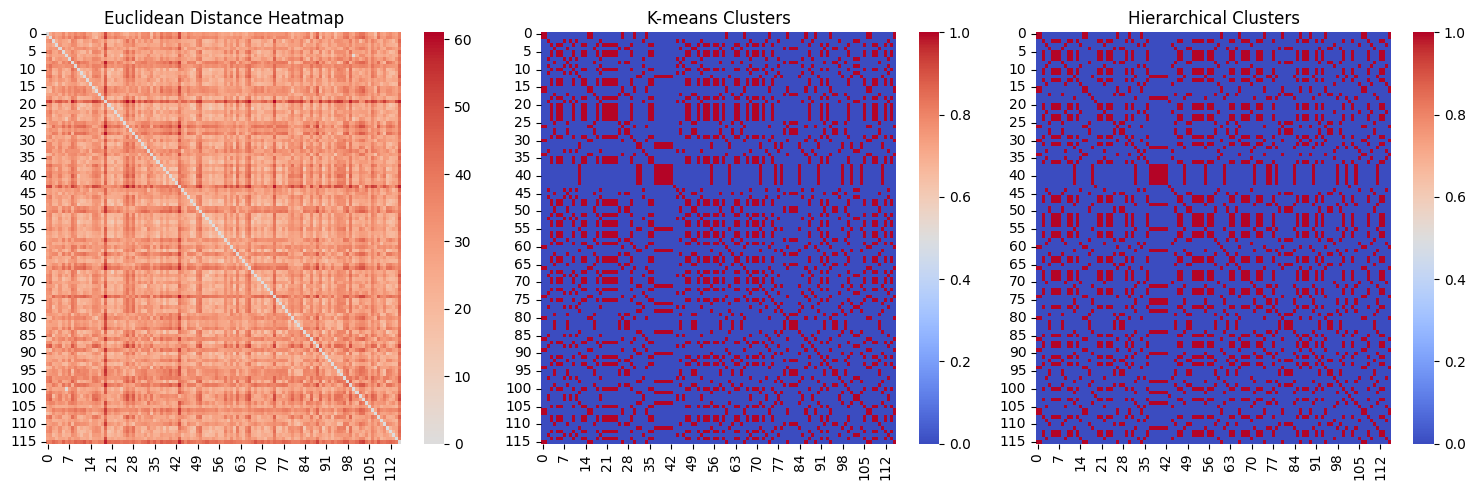


Analyzing KMEANS clusters:

Cluster_0:
Size: 1
Average distance: 0.00
Files:
  - MFCC-files-v2/44-MFCC.csv

Cluster_1:
Size: 20
Average distance: 19.92
Files:
  - MFCC-files-v2/13-MFCC.csv
  - MFCC-files-v2/32-MFCC.csv
  - MFCC-files-v2/33-MFCC.csv
  - MFCC-files-v2/38-MFCC.csv
  - MFCC-files-v2/39-MFCC.csv
  - MFCC-files-v2/40-MFCC.csv
  - MFCC-files-v2/41-MFCC.csv
  - MFCC-files-v2/42-MFCC.csv
  - MFCC-files-v2/43-MFCC.csv
  - MFCC-files-v2/56-MFCC.csv
  - MFCC-files-v2/62-MFCC.csv
  - MFCC-files-v2/72-MFCC.csv
  - MFCC-files-v2/77-MFCC.csv
  - MFCC-files-v2/79-MFCC.csv
  - MFCC-files-v2/85-MFCC.csv
  - MFCC-files-v2/91-MFCC.csv
  - MFCC-files-v2/99-MFCC.csv
  - MFCC-files-v2/102-MFCC.csv
  - MFCC-files-v2/105-MFCC.csv
  - MFCC-files-v2/112-MFCC.csv

Cluster_2:
Size: 21
Average distance: 22.86
Files:
  - MFCC-files-v2/05-MFCC.csv
  - MFCC-files-v2/09-MFCC.csv
  - MFCC-files-v2/18-MFCC.csv
  - MFCC-files-v2/26-MFCC.csv
  - MFCC-files-v2/28-MFCC.csv
  - MFCC-files-v2/29-MFCC.csv
  - M

In [7]:
X_scaled = scaler.fit_transform(features_df)


results = cluster_and_visualize(features_df, file_names, n_clusters=6)

for method in ['kmeans', 'hierarchical']:
    print(f"\nAnalyzing {method.upper()} clusters:")
    cluster_analysis = analyze_clusters(file_names, results[f'{method}_labels'],results['distance_matrix'])
    
    # Print cluster analysis
    for cluster, info in cluster_analysis.items():
        print(f"\n{cluster}:")
        print(f"Size: {info['size']}")
        print(f"Average distance: {info['avg_distance']:.2f}")
        print("Files:")
        for file in info['files']:
            print(f"  - {file}")

# Evaluate all clustering methods
for method in ['kmeans', 'hierarchical']:
    metrics = evaluate_clustering(X_scaled, results[f'{method}_labels'], method.upper())
    print_clustering_metrics(metrics, method.upper())
